In [6]:
import io

import cairosvg
import cv2
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, ImageFilter


class ImageProcessor:
    def __init__(self, image: Image.Image, seed=None):
        """Initialize with either a path to an image or a PIL Image object."""
        self.image = image
        self.original_image = self.image.copy()
        if seed is not None:
            self.rng = np.random.RandomState(seed)
        else:
            self.rng = np.random

    def reset(self):
        self.image = self.original_image.copy()
        return self

    def visualize_comparison(
        self,
        original_name="Original",
        processed_name="Processed",
        figsize=(10, 5),
        show=True,
    ):
        """Display original and processed images side by side."""
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
        ax1.imshow(np.asarray(self.original_image))
        ax1.set_title(original_name)
        ax1.axis("off")

        ax2.imshow(np.asarray(self.image))
        ax2.set_title(processed_name)
        ax2.axis("off")

        title = f"{original_name} vs {processed_name}"
        fig.suptitle(title)
        fig.tight_layout()
        if show:
            plt.show()
        return fig

    def apply_median_filter(self, size=3):
        """Apply median filter to remove outlier pixel values.

        Args:
             size: Size of the median filter window.
        """
        self.image = self.image.filter(ImageFilter.MedianFilter(size=size))
        return self

    def apply_bilateral_filter(self, d=9, sigma_color=75, sigma_space=75):
        """Apply bilateral filter to smooth while preserving edges.

        Args:
             d: Diameter of each pixel neighborhood
             sigma_color: Filter sigma in the color space
             sigma_space: Filter sigma in the coordinate space
        """
        # Convert PIL Image to numpy array for OpenCV
        img_array = np.asarray(self.image)

        # Apply bilateral filter
        filtered = cv2.bilateralFilter(img_array, d, sigma_color, sigma_space)

        # Convert back to PIL Image
        self.image = Image.fromarray(filtered)
        return self

    def apply_fft_low_pass(self, cutoff_frequency=0.5):
        """Apply low-pass filter in the frequency domain using FFT.

        Args:
             cutoff_frequency: Normalized cutoff frequency (0-1).
                  Lower values remove more high frequencies.
        """
        # Convert to numpy array, ensuring float32 for FFT
        img_array = np.array(self.image, dtype=np.float32)

        # Process each color channel separately
        result = np.zeros_like(img_array)
        for i in range(3):  # For RGB channels
            # Apply FFT
            f = np.fft.fft2(img_array[:, :, i])
            fshift = np.fft.fftshift(f)

            # Create a low-pass filter mask
            rows, cols = img_array[:, :, i].shape
            crow, ccol = rows // 2, cols // 2
            mask = np.zeros((rows, cols), np.float32)
            r = int(min(crow, ccol) * cutoff_frequency)
            center = [crow, ccol]
            x, y = np.ogrid[:rows, :cols]
            mask_area = (x - center[0]) ** 2 + (y - center[1]) ** 2 <= r * r
            mask[mask_area] = 1

            # Apply mask and inverse FFT
            fshift_filtered = fshift * mask
            f_ishift = np.fft.ifftshift(fshift_filtered)
            img_back = np.fft.ifft2(f_ishift)
            img_back = np.real(img_back)

            result[:, :, i] = img_back

        # Clip to 0-255 range and convert to uint8 after processing all channels
        result = np.clip(result, 0, 255).astype(np.uint8)

        # Convert back to PIL Image
        self.image = Image.fromarray(result)
        return self

    def apply_jpeg_compression(self, quality=85):
        """Apply JPEG compression.

        Args:
             quality: JPEG quality (0-95). Lower values increase compression.
        """
        buffer = io.BytesIO()
        self.image.save(buffer, format="JPEG", quality=quality)
        buffer.seek(0)
        self.image = Image.open(buffer)
        return self

    def apply_random_crop_resize(self, crop_percent=0.05):
        """Randomly crop and resize back to original dimensions.

        Args:
             crop_percent: Percentage of image to crop (0-0.4).
        """
        width, height = self.image.size
        crop_pixels_w = int(width * crop_percent)
        crop_pixels_h = int(height * crop_percent)

        left = self.rng.randint(0, crop_pixels_w + 1)
        top = self.rng.randint(0, crop_pixels_h + 1)
        right = width - self.rng.randint(0, crop_pixels_w + 1)
        bottom = height - self.rng.randint(0, crop_pixels_h + 1)

        self.image = self.image.crop((left, top, right, bottom))
        self.image = self.image.resize((width, height), Image.BILINEAR)
        return self

    def apply(self):
        """Apply an ensemble of defenses."""
        return (
            self.apply_random_crop_resize(crop_percent=0.03)
            .apply_jpeg_compression(quality=95)
            .apply_median_filter(size=9)
            .apply_fft_low_pass(cutoff_frequency=0.5)
            .apply_bilateral_filter(d=5, sigma_color=75, sigma_space=75)
            .apply_jpeg_compression(quality=92)
        )


def svg_to_png(svg_code: str, size: tuple = (384, 384)) -> Image.Image:
    """
    Converts an SVG string to a PNG image using CairoSVG.

    If the SVG does not define a `viewBox`, it will add one using the provided size.

    Parameters
    ----------
    svg_code : str
         The SVG string to convert.
    size : tuple[int, int], default=(384, 384)
         The desired size of the output PNG image (width, height).

    Returns
    -------
    PIL.Image.Image
         The generated PNG image.
    """
    # Ensure SVG has proper size attributes
    if "viewBox" not in svg_code:
        svg_code = svg_code.replace("<svg", f'<svg viewBox="0 0 {size[0]} {size[1]}"')

    # Convert SVG to PNG
    png_data = cairosvg.svg2png(bytestring=svg_code.encode("utf-8"))
    return Image.open(io.BytesIO(png_data)).convert("RGB").resize(size)


In [7]:
from dataclasses import dataclass, field

from defusedxml import ElementTree as etree


@dataclass(frozen=True)
class SVGConstraints:
    """Defines constraints for validating SVG documents.

    Attributes
    ----------
    max_svg_size : int, default=10000
        Maximum allowed size of an SVG file in bytes.
    allowed_elements : dict[str, set[str]]
        Mapping of the allowed elements to the allowed attributes of each element.
    """

    max_svg_size: int = 10000
    allowed_elements: dict[str, set[str]] = field(
        default_factory=lambda: {
            'common': {
                'id',
                'clip-path',
                'clip-rule',
                'color',
                'color-interpolation',
                'color-interpolation-filters',
                'color-rendering',
                'display',
                'fill',
                'fill-opacity',
                'fill-rule',
                'filter',
                'flood-color',
                'flood-opacity',
                'lighting-color',
                'marker-end',
                'marker-mid',
                'marker-start',
                'mask',
                'opacity',
                'paint-order',
                'stop-color',
                'stop-opacity',
                'stroke',
                'stroke-dasharray',
                'stroke-dashoffset',
                'stroke-linecap',
                'stroke-linejoin',
                'stroke-miterlimit',
                'stroke-opacity',
                'stroke-width',
                'transform',
            },
            'svg': {
                'width',
                'height',
                'viewBox',
                'preserveAspectRatio',
            },
            'g': {'viewBox'},
            'defs': set(),
            'symbol': {'viewBox', 'x', 'y', 'width', 'height'},
            'use': {'x', 'y', 'width', 'height', 'href'},
            'marker': {
                'viewBox',
                'preserveAspectRatio',
                'refX',
                'refY',
                'markerUnits',
                'markerWidth',
                'markerHeight',
                'orient',
            },
            'pattern': {
                'viewBox',
                'preserveAspectRatio',
                'x',
                'y',
                'width',
                'height',
                'patternUnits',
                'patternContentUnits',
                'patternTransform',
                'href',
            },
            'linearGradient': {
                'x1',
                'x2',
                'y1',
                'y2',
                'gradientUnits',
                'gradientTransform',
                'spreadMethod',
                'href',
            },
            'radialGradient': {
                'cx',
                'cy',
                'r',
                'fx',
                'fy',
                'fr',
                'gradientUnits',
                'gradientTransform',
                'spreadMethod',
                'href',
            },
            'stop': {'offset'},
            'filter': {
                'x',
                'y',
                'width',
                'height',
                'filterUnits',
                'primitiveUnits',
            },
            'feBlend': {'result', 'in', 'in2', 'mode'},
            'feColorMatrix': {'result', 'in', 'type', 'values'},
            'feComposite': {
                'result',
                'style',
                'in',
                'in2',
                'operator',
                'k1',
                'k2',
                'k3',
                'k4',
            },
            'feFlood': {'result'},
            'feGaussianBlur': {
                'result',
                'in',
                'stdDeviation',
                'edgeMode',
            },
            'feMerge': {
                'result',
                'x',
                'y',
                'width',
                'height',
                'result',
            },
            'feMergeNode': {'result', 'in'},
            'feOffset': {'result', 'in', 'dx', 'dy'},
            'feTurbulence': {
                'result',
                'baseFrequency',
                'numOctaves',
                'seed',
                'stitchTiles',
                'type',
            },
            'path': {'d'},
            'rect': {'x', 'y', 'width', 'height', 'rx', 'ry'},
            'circle': {'cx', 'cy', 'r'},
            'ellipse': {'cx', 'cy', 'rx', 'ry'},
            'line': {'x1', 'y1', 'x2', 'y2'},
            'polyline': {'points'},
            'polygon': {'points'},
        }
    )

    def validate_svg(self, svg_code: str) -> None:
        """Validates an SVG string against a set of predefined constraints.

        Parameters
        ----------
        svg_code : str
            The SVG string to validate.

        Raises
        ------
        ValueError
            If the SVG violates any of the defined constraints.
        """
        # Check file size
        if len(svg_code.encode('utf-8')) > self.max_svg_size:
            raise ValueError('SVG exceeds allowed size')

        # Parse XML
        tree = etree.fromstring(
            svg_code.encode('utf-8'),
            forbid_dtd=True,
            forbid_entities=True,
            forbid_external=True,
        )

        elements = set(self.allowed_elements.keys())

        # Check elements and attributes
        for element in tree.iter():
            # Check for disallowed elements
            tag_name = element.tag.split('}')[-1]
            if tag_name not in elements:
                raise ValueError(f'Disallowed element: {tag_name}')

            # Check attributes
            for attr, attr_value in element.attrib.items():
                # Check for disallowed attributes
                attr_name = attr.split('}')[-1]
                if (
                    attr_name not in self.allowed_elements[tag_name]
                    and attr_name not in self.allowed_elements['common']
                ):
                    raise ValueError(f'Disallowed attribute: {attr_name}')

                # Check for embedded data
                if 'data:' in attr_value.lower():
                    raise ValueError('Embedded data not allowed')
                if ';base64' in attr_value:
                    raise ValueError('Base64 encoded content not allowed')

                # Check that href attributes are internal references
                if attr_name == 'href':
                    if not attr_value.startswith('#'):
                        raise ValueError(
                            f'Invalid href attribute in <{tag_name}>. Only internal references (starting with "#") are allowed. Found: "{attr_value}"'
                        )


if __name__ == '__main__':
    svg_validator = SVGConstraints()

    valid_svg = """
    <svg width="100" height="100">
      <circle cx="50" cy="50" r="40" stroke="green" stroke-width="4" fill="yellow" />
    </svg>
    """

    invalid_size_svg = '<svg>' + ' ' * 6000 + '</svg>'  # Exceeds default 5000 bytes

    invalid_element_svg = """
    <svg>
      <script>alert('bad');</script>
    </svg>
    """

    invalid_attribute_svg = """
    <svg>
      <rect width="100" height="100" onclick="alert('bad')"/>
    </svg>
    """

    invalid_href_svg = """
    <svg>
      <use href="http://example.com/image.svg" />
    </svg>
    """

    invalid_embedded_image_element_svg = """
    <svg width="100" height="100">
      <image href="data:image/png;base64,iVBOAAAANSUhEUgAAAAUAAAAFCAYAAACN==" width="50" height="50"/>
    </svg>
    """

    invalid_data_uri_attribute_svg = """
    <svg width="100" height="100">
      <rect width="50" height="50" fill="url(data:image/png;base64,iVBOAAAANSUhEUgAAAAUAAAAFCAYAAACN==)" />
    </svg>
    """

    print('Running SVG validation examples:')

    print('\nValid SVG example:')
    svg_validator.validate_svg(valid_svg)
    print('  Validation successful!')

    print('\nSVG exceeding size limit:')
    try:
        svg_validator.validate_svg(invalid_size_svg)
        print('  Validation successful! (This should not happen)')
    except ValueError as e:
        print(f'  Validation failed as expected with error: {e}')

    print('\nSVG with disallowed element:')
    try:
        svg_validator.validate_svg(invalid_element_svg)
        print('  Validation successful! (This should not happen)')
    except ValueError as e:
        print(f'  Validation failed as expected with error: {e}')

    print('\nSVG with disallowed attribute:')
    try:
        svg_validator.validate_svg(invalid_attribute_svg)
        print('  Validation successful! (This should not happen)')
    except ValueError as e:
        print(f'  Validation failed as expected with error: {e}')

    print('\nSVG with invalid external href:')
    try:
        svg_validator.validate_svg(invalid_href_svg)
        print('  Validation successful! (This should not happen)')
    except ValueError as e:
        print(f'  Validation failed as expected with error: {e}')

    print('\nSVG with disallowed <image> element:')
    try:
        svg_validator.validate_svg(invalid_embedded_image_element_svg)
        print('  Validation successful! (This should not happen)')
    except ValueError as e:
        print(f'  Validation failed as expected with error: {e}')

    print('\nSVG with invalid data URI in attribute (fill):')
    try:
        svg_validator.validate_svg(invalid_data_uri_attribute_svg)
        print('  Validation successful! (This should not happen)')
    except ValueError as e:
        print(f'  Validation failed as expected with error: {e}')


Running SVG validation examples:

Valid SVG example:
  Validation successful!

SVG exceeding size limit:
  Validation successful! (This should not happen)

SVG with disallowed element:
  Validation failed as expected with error: Disallowed element: script

SVG with disallowed attribute:
  Validation failed as expected with error: Disallowed attribute: onclick

SVG with invalid external href:
  Validation failed as expected with error: Invalid href attribute in <use>. Only internal references (starting with "#") are allowed. Found: "http://example.com/image.svg"

SVG with disallowed <image> element:
  Validation failed as expected with error: Disallowed element: image

SVG with invalid data URI in attribute (fill):
  Validation failed as expected with error: Embedded data not allowed


In [14]:
import os

import clip
import torch
import torch.nn as nn
from PIL import Image

# from configs.configs import MODEL_DIR


class AestheticPredictor(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.input_size = input_size
        self.layers = nn.Sequential(
            nn.Linear(self.input_size, 1024),
            nn.Dropout(0.2),
            nn.Linear(1024, 128),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.Dropout(0.1),
            nn.Linear(64, 16),
            nn.Linear(16, 1),
        )

    def forward(self, x):
        return self.layers(x)


class AestheticEvaluator:
    def __init__(self):
        self.model_path = r"/home/anhndt/draw-with-llm/models/sac+logos+ava1-l14-linearMSE.pth"
        self.clip_model_path = r"/home/anhndt/draw-with-llm/models/ViT-L-14.pt"
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.predictor, self.clip_model, self.preprocessor = self.load()

    def load(self):
        """Loads the aesthetic predictor model and CLIP model."""
        state_dict = torch.load(
            self.model_path, weights_only=True, map_location=self.device
        )

        # CLIP embedding dim is 768 for CLIP ViT L 14
        predictor = AestheticPredictor(768)
        predictor.load_state_dict(state_dict)
        predictor.to(self.device)
        predictor.eval()
        clip_model, preprocessor = clip.load(self.clip_model_path, device=self.device)

        return predictor, clip_model, preprocessor

    def score(self, image: Image.Image) -> float:
        """Predicts the CLIP aesthetic score of an image."""
        image = self.preprocessor(image).unsqueeze(0).to(self.device)

        with torch.no_grad():
            image_features = self.clip_model.encode_image(image)
            # l2 normalize
            image_features /= image_features.norm(dim=-1, keepdim=True)
            image_features = image_features.cpu().detach().numpy()

        score = self.predictor(torch.from_numpy(image_features).to(self.device).float())

        return score.item() / 10.0  # scale to [0, 1]

    def compute_clip_similarity(self, image: Image.Image, text: str) -> float:
        """
        Compute the similarity score between an image and a text using the CLIP model.

        Args:
            image (PIL.Image.Image): The input image to be compared.
            text (str): The text description to compare with the image.

        Returns:
            float: A similarity score between the image and text embeddings.
                Higher scores indicate greater similarity.
        """

        # Preprocess the image (resize, normalize, etc.), add batch dimension, and move to the correct device
        image = self.preprocessor(image).unsqueeze(0).to(self.device)

        # Tokenize the input text and move it to the correct device
        text = clip.tokenize([text]).to(self.device)

        # Disable gradient computation for inference
        with torch.no_grad():
            # Extract image features using CLIP
            image_features = self.clip_model.encode_image(image)
            # Extract text features using CLIP
            text_features = self.clip_model.encode_text(text)

        # Compute cosine similarity (dot product since CLIP features are normalized)
        similarity = (image_features @ text_features.T).item()

        return similarity


In [15]:
aesthetic_evaluator = AestheticEvaluator()

In [ ]:
import json
from tqdm import tqdm

In [20]:
import json
import pandas as pd

train_path = r"/home/anhndt/draw-with-llm/data/raw/ColorSVG-100K/train.json"

# Đọc file JSON
with open(train_path, 'r', encoding="utf-8") as f:
    train_svg = json.load(f)

# Chuyển đổi thành DataFrame
train_df = pd.DataFrame(train_svg)

# Hiển thị thông tin DataFrame
print(train_df.head())

        category                                                svg
0     light bulb  <svg xmlns="http://www.w3.org/2000/svg" viewBo...
1            can  <svg xmlns="http://www.w3.org/2000/svg" viewBo...
2          yacht  <svg xmlns="http://www.w3.org/2000/svg" viewBo...
3  first aid kit  <svg xmlns="http://www.w3.org/2000/svg" viewBo...
4          lemon  <svg xmlns="http://www.w3.org/2000/svg" viewBo...


In [18]:
result = []

Số lượng luồng khả dụng: 8


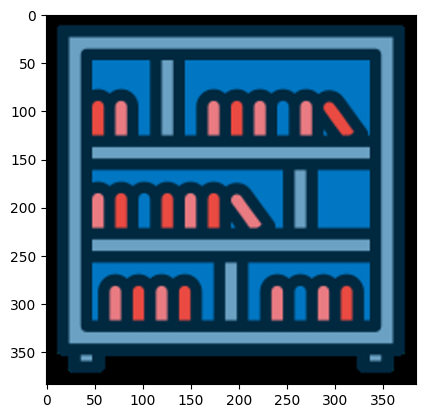

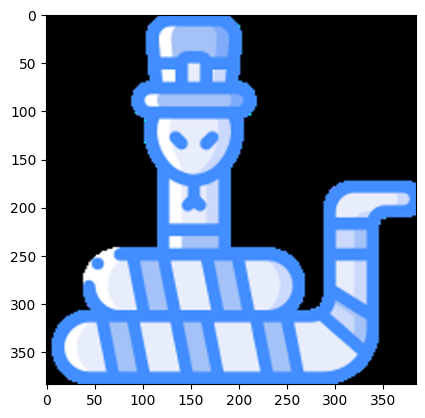

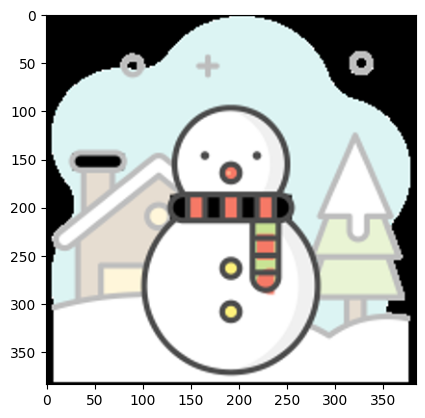

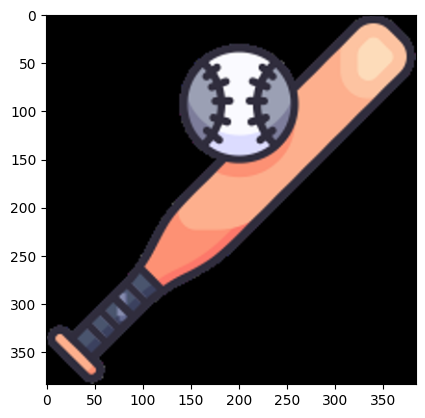

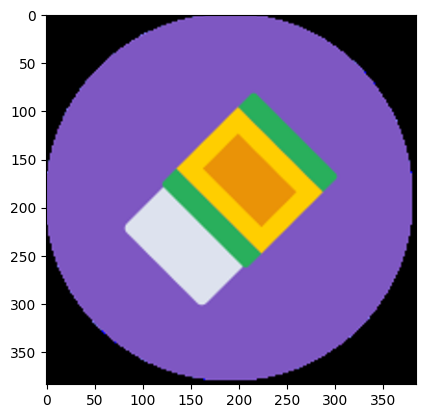

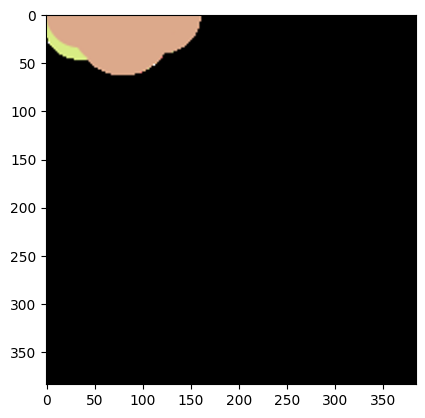

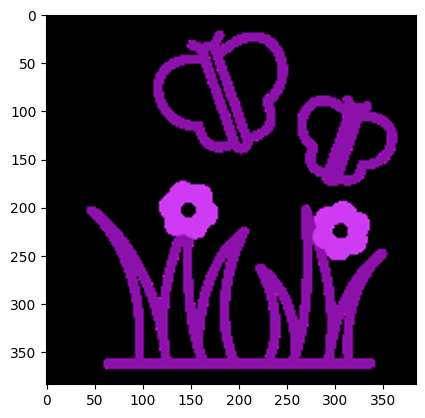

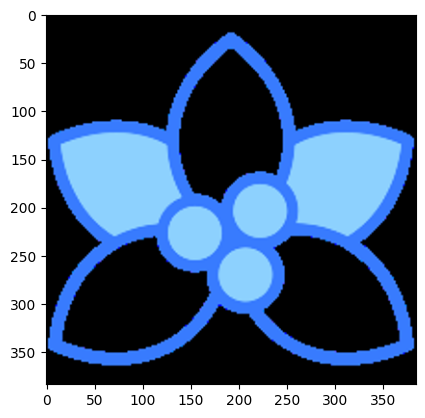

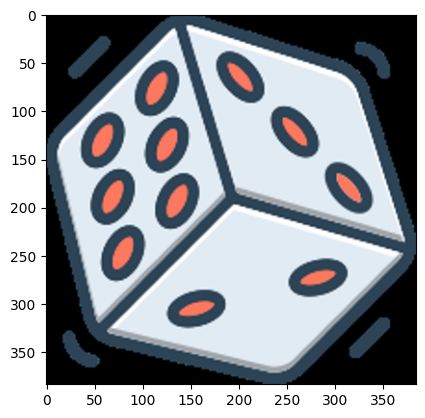

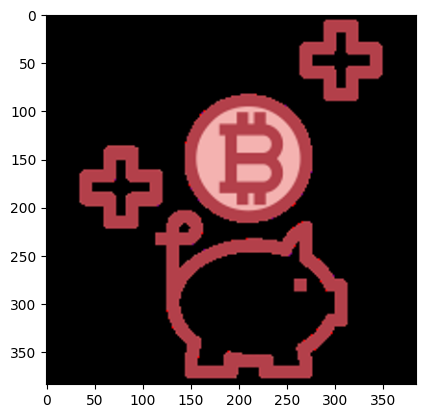

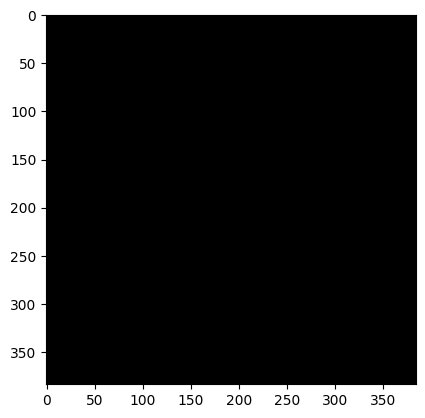

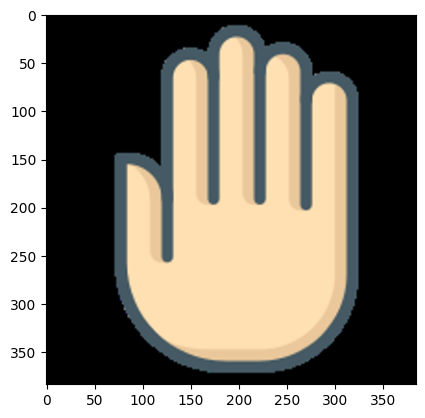

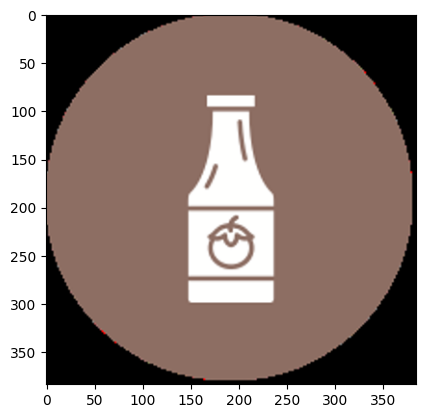

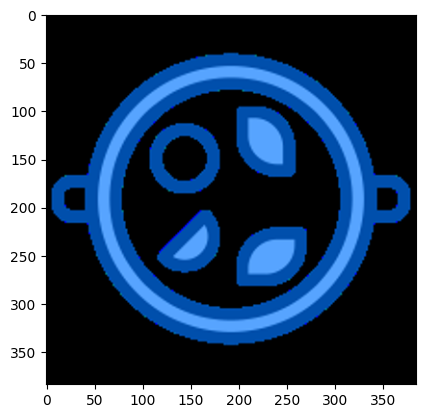

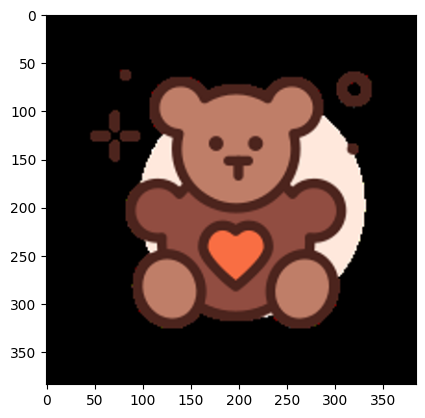

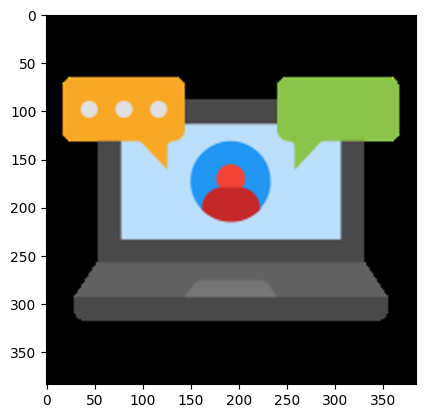

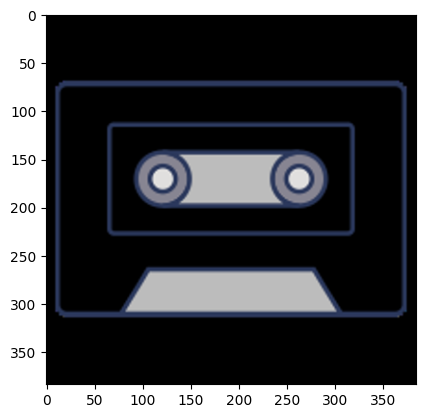

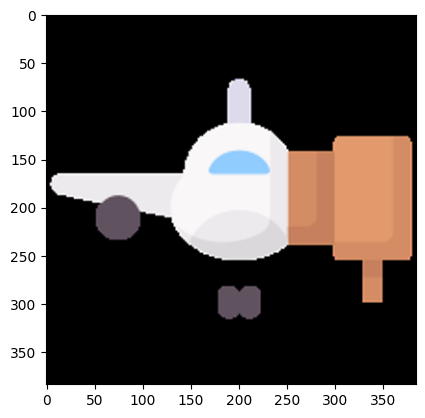

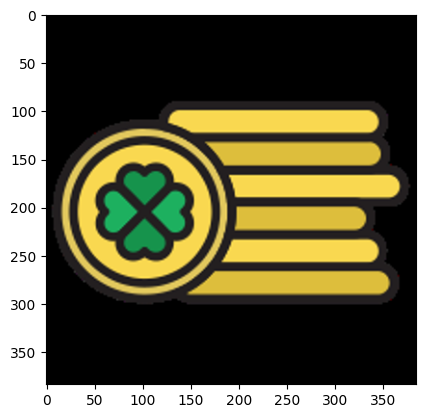

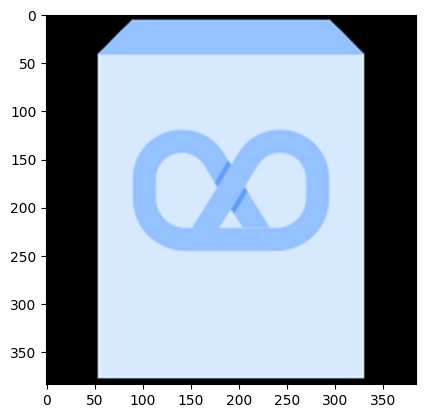

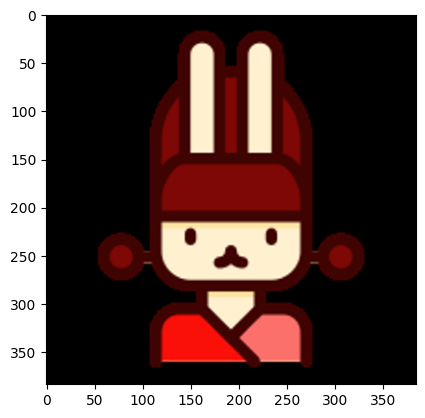

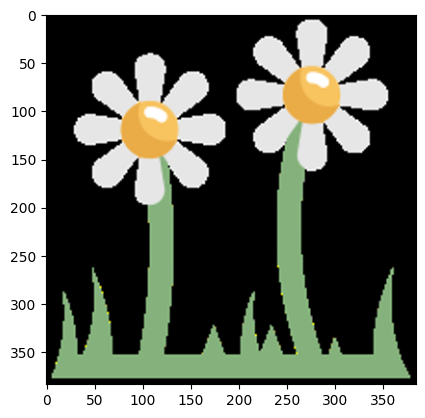

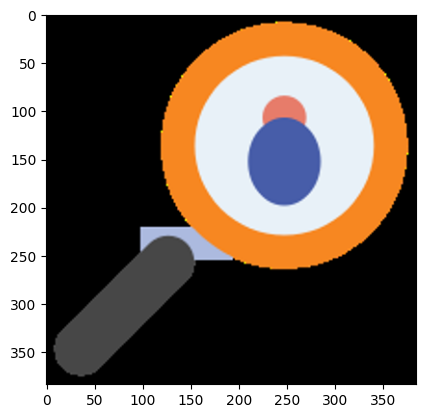

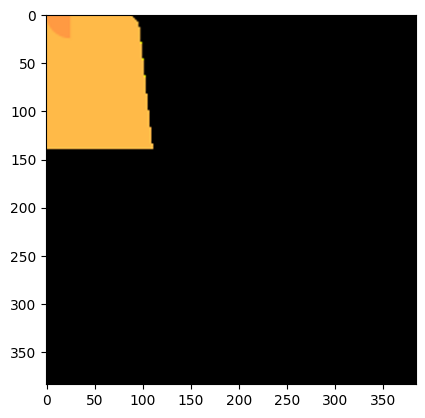

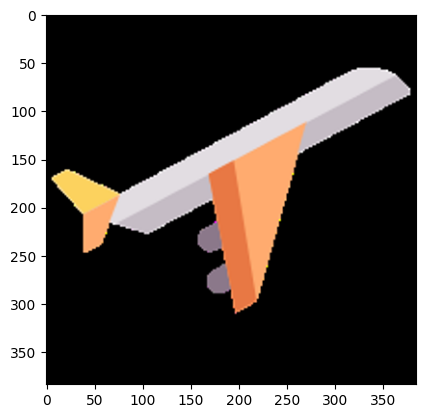

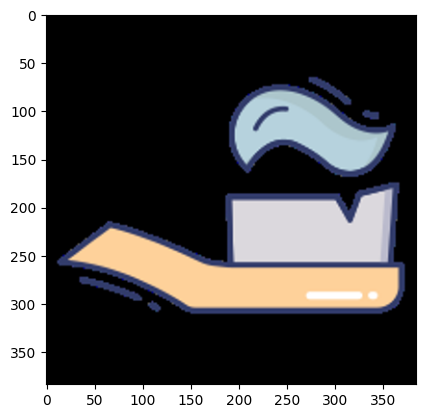

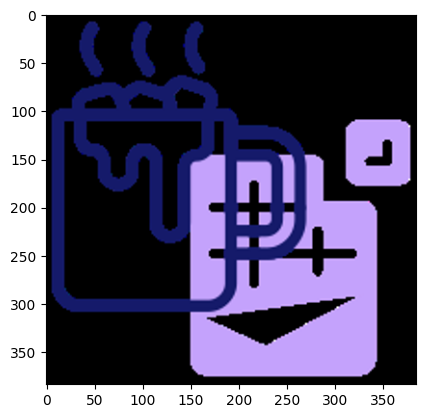

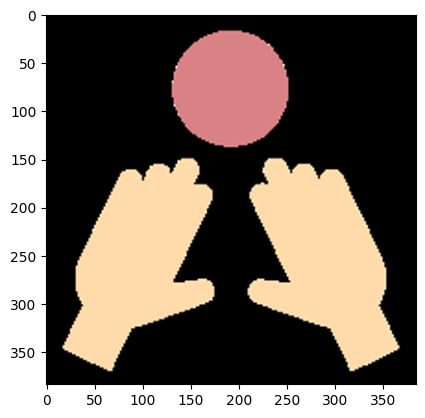

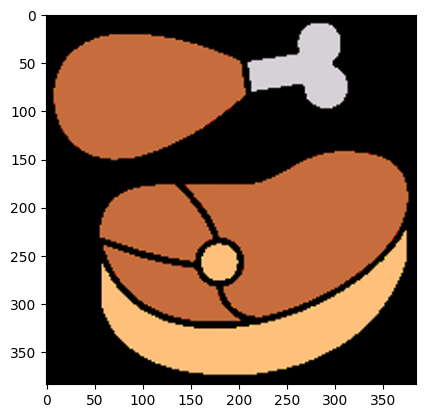

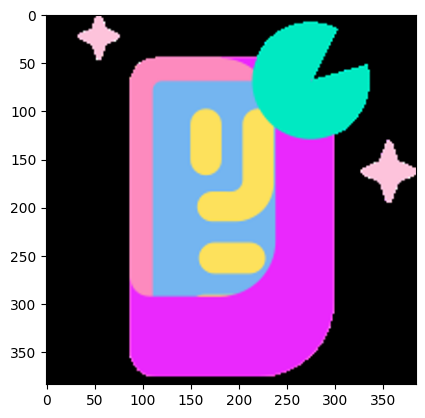

Hoàn thành xử lý!


In [42]:
import os
import concurrent.futures
from tqdm import tqdm
import random
import numpy as np
import matplotlib.pyplot as plt

# Kiểm tra số lượng luồng khả dụng
num_threads = os.cpu_count()
print(f"Số lượng luồng khả dụng: {num_threads}")

# Lấy 3000 mẫu ngẫu nhiên từ train_svg
train_svg_sample = random.sample(train_svg, 30)

# Hàm xử lý từng mục trong train_svg
def process_svg(svg_item):
    svg = svg_item.get("svg")
    image = svg_to_png(svg)
    plt.imshow(image)
    plt.show
    # aesthetic_score = aesthetic_evaluator.score(image)
    return 0.1

# Khởi tạo RandomState
rng = np.random.RandomState(42)

# Sử dụng ThreadPoolExecutor để chạy đa luồng
result = []
# with concurrent.futures.ThreadPoolExecutor(max_workers=num_threads) as executor:
#     # Sử dụng tqdm để hiển thị tiến trình
#     futures = list(tqdm(executor.map(process_svg, train_svg_sample), total=len(train_svg_sample)))
#     result.extend(futures)
for i, item in enumerate(train_svg_sample):
    svg = item.get("svg")
    img = svg_to_png(svg)

    plt.imshow(img)
    plt.show()

# Kết quả
print("Hoàn thành xử lý!")

In [29]:
avg = sum(i for i in result) / len(train_svg_sample)
print(avg)

0.46592797942161474


In [ ]:
import pandas as pd
score = pd.read_csv(r"/home/anhndt/draw-with-llm/data/results/score/prompt_summary.csv")


# Thiết lập để hiển thị toàn bộ nội dung cột (không giới hạn độ rộng)
pd.set_option('display.max_colwidth', None)

# Thiết lập để hiển thị nhiều cột hơn (nếu có nhiều cột)
pd.set_option('display.max_columns', None)

# Thiết lập độ rộng hiển thị tổng thể (hữu ích trong terminal)
pd.set_option('display.width', 1000)

# Sau đó hiển thị DataFrame của bạn
print(score)

         filename  avg_total_score  avg_vqa_score  avg_aesthetic_score  avg_ocr_score                                                                   Summary
0  version_1.json           0.6281         0.7086               0.4538         1.0000  Full method (SVG, CLIP, Text, Aesthetic), 768x768, 25 steps, 3 attempts.
1  version_2.json           0.6235         0.6979               0.4705         1.0000                                    Like v1, but method omits Text_Insert.
2  version_4.json           0.6439         0.7386               0.4417         1.0000                  Like v1, but omits Aesthetic & num_inference_steps = 35.
3  version_6.json           0.6254         0.7289               0.4290         1.0000                          Like v1, but omits Aesthetic & num_attempts = 4.
4  version_7.json           0.6262         0.7093               0.4572         1.0000                                            Like v1, but num_attempts = 4.
5  version_8.json           0.5001      

In [1]:
import ImageReward as RM
model = RM.load("ImageReward-v1.0")

/home/anhndt/.conda/envs/draw-with-llm/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


load checkpoint from /home/anhndt/.cache/ImageReward/ImageReward.pt
checkpoint loaded


In [8]:
image = r"/home/anhndt/draw-with-llm/data/results/version_0.599--image_compression/996c3a/raw - 0 - 0.4834.png"


In [9]:
model.score("a snowy plain", image)

-2.270742416381836